# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Transcriptomics" data-toc-modified-id="Transcriptomics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Transcriptomics</a></div><div class="lev2 toc-item"><a href="#Log-Transformations-and-DEG-analysis" data-toc-modified-id="Log-Transformations-and-DEG-analysis-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Log Transformations and DEG analysis</a></div><div class="lev2 toc-item"><a href="#Prepping-the-data" data-toc-modified-id="Prepping-the-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prepping the data</a></div><div class="lev2 toc-item"><a href="#Explore-the-data" data-toc-modified-id="Explore-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Explore the data</a></div><div class="lev2 toc-item"><a href="#DEG-analysis" data-toc-modified-id="DEG-analysis-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>DEG analysis</a></div>

# Transcriptomics
## Log Transformations and DEG analysis

By: Caroline Labelle
<br>For: BCM6065-65

<br>
Date: July  5th 2022

<hr style="border:1px solid black"> </hr>


## Prepping the data

To do the DEG analysis, we will be using a R package called Limma Voom. We first need to prep our data so that we have a single file to upload in R.

You were initially handed 6 unstranded RNA-seq samples of MCF7 cells (breast cancer): three of the samples were threated with estradiol (E2). You used STAR to align the reads and do the gene quantification. You now have 6 files with the suffix <code>ReadsPerGene.out.tab</code>.

SRR1012918 -> **treatment**<br>
SRR1012920 -> **treatment**<br>
SRR1012922 -> **treatment**<br>

SRR1012936 -> **control**<br>
SRR1012939 -> **control**<br>
SRR1012942 -> **control**<br>

Publication for the data: https://pubmed.ncbi.nlm.nih.gov/24319002/
<br>STAR documentation: https://physiology.med.cornell.edu/faculty/skrabanek/lab/angsd/lecture_notes/STARmanual.pdf

In [1]:
### Import pandas, numpy and seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [2]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.set_theme(context="notebook", style="white", palette="Set2")

In [3]:
### Import one DF
df_18=pd.read_csv("STAR_SRR1012918ReadsPerGene.out.tab", sep="\t", header=None)
df_18

,0,1,2,3
0,N_unmapped,4211944,4211944,4211944
1,N_multimapping,0,0,0
2,N_noFeature,812921,9187413,9390931
3,N_ambiguous,1484530,410100,369058
4,ENSG00000223972,1,1,0
...,...,...,...,...
60674,ENSG00000271254,209,98,111
60675,ENSG00000275405,0,0,0
60676,ENSG00000275987,0,0,0
60677,ENSG00000277475,0,0,0


In [4]:
### Keep gene rows and unstranded counts
df_clean=df_18.iloc[4:,0:2]
df_clean.columns=['Gene', 'Treatment_1']
df_clean

,Gene,Treatment_1
4,ENSG00000223972,1
5,ENSG00000227232,1
6,ENSG00000278267,0
7,ENSG00000243485,0
8,ENSG00000284332,0
...,...,...
60674,ENSG00000271254,209
60675,ENSG00000275405,0
60676,ENSG00000275987,0
60677,ENSG00000277475,0


In [5]:
### Import all data into one DF
current_path=os.getcwd()
dirs = os.listdir(current_path)

fn_list = [name for name in dirs if "tab" in name]
fn_list

label_list = ['Treatment_1', 'Treatment_2', 'Treatment_3', 'Control_1', 'Control_2', 'Control_3']
final_df=df_clean
for i in range (1,len(label_list)):
    tmp=pd.read_csv(fn_list[i], sep="\t", header=None)
    tmp=tmp.iloc[4:,0:2]
    tmp.columns=['Gene', label_list[i]]
    final_df=final_df.merge(tmp, on='Gene')

final_df

,Gene,Treatment_1,Treatment_2,Treatment_3,Control_1,Control_2,Control_3
0,ENSG00000223972,1,0,0,0,0,0
1,ENSG00000227232,1,0,0,1,0,1
2,ENSG00000278267,0,0,0,0,0,0
3,ENSG00000243485,0,0,0,0,0,0
4,ENSG00000284332,0,0,0,0,0,0
...,...,...,...,...,...,...,...
60670,ENSG00000271254,209,251,285,180,160,229
60671,ENSG00000275405,0,0,0,0,0,0
60672,ENSG00000275987,0,0,0,0,0,0
60673,ENSG00000277475,0,0,0,0,0,0


In [6]:
### Export the dataframe to a tsv
final_df.to_csv('all_results.tsv', sep="\t", index=False)

## Explore the data

In [7]:
### Calculate the average ratio of Treatment1 vs. Control1
### Is there a problem?
print(final_df['Treatment_1']/final_df['Control_1'])
#there are loaaaads of NaNs and infinite values

0             inf
1        1.000000
2             NaN
3             NaN
4             NaN
           ...   
60670    1.161111
60671         NaN
60672         NaN
60673         NaN
60674         NaN
Length: 60675, dtype: float64


In [8]:
### Calculate the average log10 ratio of Treatment1 vs. Control1
c=0.001

transformed_df=final_df.copy()
transformed_df[transformed_df.columns[1:]]=transformed_df[transformed_df.columns[1:]]+c

transformed_df

,Gene,Treatment_1,Treatment_2,Treatment_3,Control_1,Control_2,Control_3
0,ENSG00000223972,1.001,0.001,0.001,0.001,0.001,0.001
1,ENSG00000227232,1.001,0.001,0.001,1.001,0.001,1.001
2,ENSG00000278267,0.001,0.001,0.001,0.001,0.001,0.001
3,ENSG00000243485,0.001,0.001,0.001,0.001,0.001,0.001
4,ENSG00000284332,0.001,0.001,0.001,0.001,0.001,0.001
...,...,...,...,...,...,...,...
60670,ENSG00000271254,209.001,251.001,285.001,180.001,160.001,229.001
60671,ENSG00000275405,0.001,0.001,0.001,0.001,0.001,0.001
60672,ENSG00000275987,0.001,0.001,0.001,0.001,0.001,0.001
60673,ENSG00000277475,0.001,0.001,0.001,0.001,0.001,0.001


In [9]:
new_df=pd.Series((np.log10(transformed_df['Treatment_1'])-np.log10(transformed_df['Control_1'])))
avg=new_df.mean()

In [10]:
print("The average log10 ratio of Treatment1 vs. Control1 is "+str(avg)+".")

The average log10 ratio of Treatment1 vs. Control1 is 0.07096367555776602.


In [11]:
### Add columns to the df with log10-transformed data

for col in transformed_df.columns[1:]:
    name='Log_'+col
    transformed_df[name]=np.log10(transformed_df[col])
transformed_df

,Gene,Treatment_1,Treatment_2,Treatment_3,Control_1,Control_2,Control_3,Log_Treatment_1,Log_Treatment_2,Log_Treatment_3,Log_Control_1,Log_Control_2,Log_Control_3
0,ENSG00000223972,1.001,0.001,0.001,0.001,0.001,0.001,0.000434,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
1,ENSG00000227232,1.001,0.001,0.001,1.001,0.001,1.001,0.000434,-3.000000,-3.000000,0.000434,-3.000000,0.000434
2,ENSG00000278267,0.001,0.001,0.001,0.001,0.001,0.001,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
3,ENSG00000243485,0.001,0.001,0.001,0.001,0.001,0.001,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
4,ENSG00000284332,0.001,0.001,0.001,0.001,0.001,0.001,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60670,ENSG00000271254,209.001,251.001,285.001,180.001,160.001,229.001,2.320148,2.399675,2.454846,2.255275,2.204123,2.359837
60671,ENSG00000275405,0.001,0.001,0.001,0.001,0.001,0.001,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
60672,ENSG00000275987,0.001,0.001,0.001,0.001,0.001,0.001,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
60673,ENSG00000277475,0.001,0.001,0.001,0.001,0.001,0.001,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000


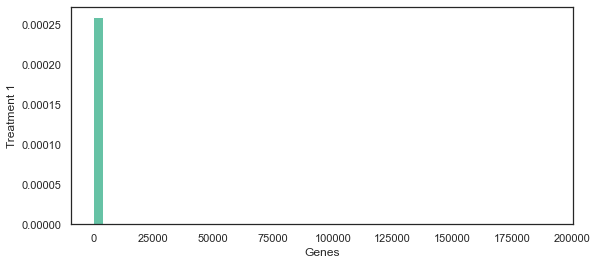

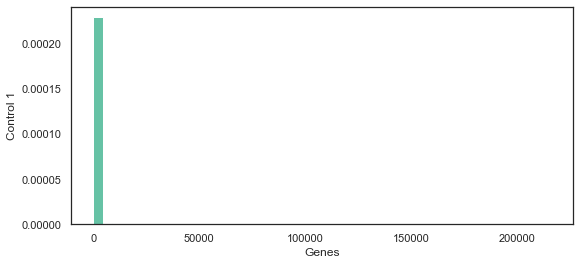

In [12]:
import matplotlib.pyplot as plt
plt.hist(transformed_df['Treatment_1'], density=True, bins=50)  # density=False would make counts
plt.ylabel('Treatment 1')
plt.xlabel('Genes');
plt.show()

plt.hist(transformed_df['Control_1'], density=True, bins=50)
plt.ylabel('Control 1')
plt.xlabel('Genes');
plt.show()

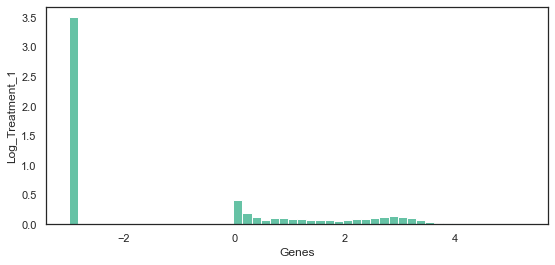

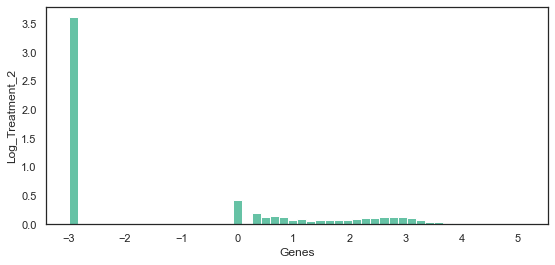

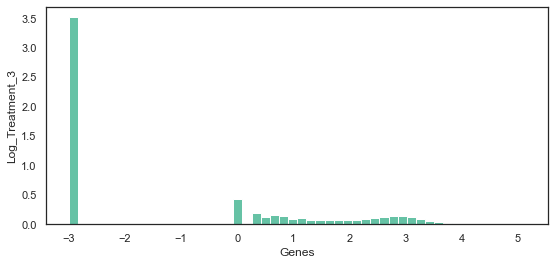

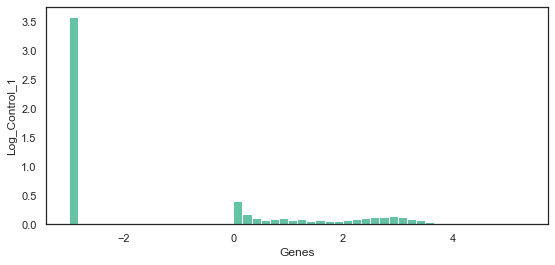

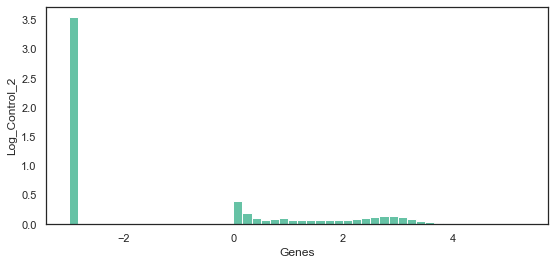

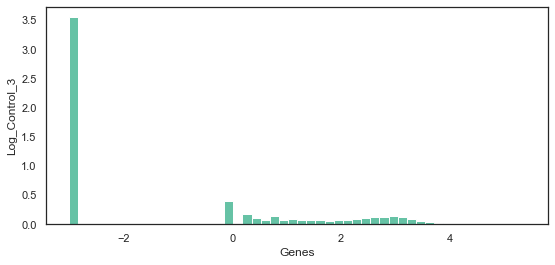

The data is much easier to visualize with the log scale. 


In [13]:
### Plot the log10 expression values of all samples
### What do you observe?
for col in transformed_df.columns:
    if "Log" in col:
        plt.hist(transformed_df[col], density=True, bins=50)  # density=False would make counts
        plt.ylabel(col)
        plt.xlabel('Genes');
        plt.show()
print('The data is much easier to visualize with the log scale. ')

# DO DEG ANALYSIS IN R

## DEG analysis

In [14]:
### Upload DEG analysis
deg_df=pd.read_csv("deg_results.tsv", sep='\t')
deg_df

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,ENSG00000147255,-4.212719,5.036796,-32.540700,1.016408e-07,0.001858,8.565757
1,ENSG00000151892,-2.530967,5.702625,-31.925158,1.133285e-07,0.001858,8.615937
2,ENSG00000213673,-4.730086,-2.601906,-31.415734,1.242076e-07,0.001858,5.558399
3,ENSG00000074527,1.339166,7.366807,31.233154,1.284020e-07,0.001858,8.644275
4,ENSG00000151224,-5.105304,-2.408434,-29.574816,1.752000e-07,0.001858,5.565237
...,...,...,...,...,...,...,...
60670,ENSG00000160712,-0.000042,3.868950,-0.000553,9.995777e-01,0.999644,-7.423323
60671,ENSG00000249459,0.000092,1.509919,0.000448,9.996581e-01,0.999708,-7.087901
60672,ENSG00000011405,0.000052,6.717332,0.000186,9.998577e-01,0.999877,-7.698110
60673,ENSG00000180245,0.000180,-4.057159,0.000161,9.998769e-01,0.999877,-6.226297


In [18]:
### Explore the data
deg_df.describe()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
count,60675.000000,60675.000000,60675.000000,6.067500e+04,60675.000000,60675.000000
mean,-0.128468,-2.268586,-0.456518,4.346480e-01,0.605148,-5.620537
std,0.560689,3.965525,2.071255,2.456555e-01,0.180965,1.561063
min,-5.577449,-4.912039,-32.540700,1.016408e-07,0.001858,-8.097612
25%,-0.144917,-4.912039,-0.619249,2.072018e-01,0.641606,-6.129334
50%,-0.104269,-4.647879,-0.619249,5.595625e-01,0.641606,-6.129334
75%,-0.034068,-0.777076,-0.107050,5.595625e-01,0.641606,-5.613302
max,3.286009,13.591217,31.233154,9.998769e-01,0.999877,8.644275


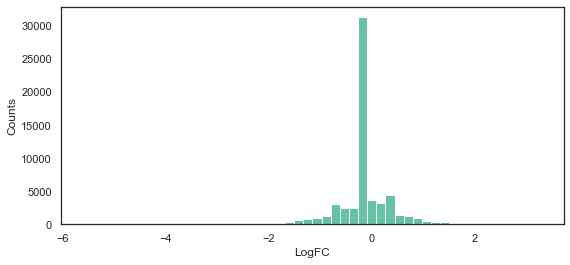

In [22]:
plt.hist(deg_df["logFC"], density=False, bins=50)  # density=False would make counts
plt.ylabel("Counts")
plt.xlabel("LogFC")
plt.show()
        

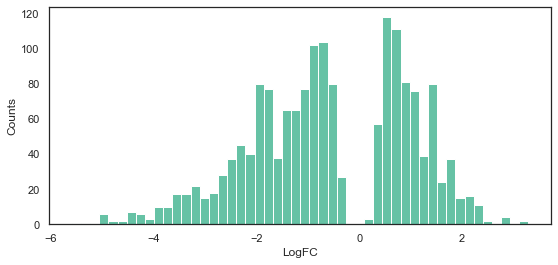

In [26]:
### Confirm (or infirm your hypothesis) 
#We want the values that we deem statistically significant
p_threshold=0.05
plt.hist(deg_df[deg_df['adj.P.Val']<p_threshold]["logFC"], density=False, bins=50)  # density=False would make counts
plt.ylabel("Counts")
plt.xlabel("LogFC")
plt.show()

In [27]:
print('A lot of genes are differentially expressed between the treatment and the control: the hypothesis was right.')

A lot of genes are differentially expressed between the treatment and the control: the hypothesis was right.


In [35]:
deg_df[deg_df['adj.P.Val']<p_threshold]["genes"].to_csv('deg2.csv', index=None) #getting a list of differentially 
#affected genes into a file

In [40]:
data = pd.read_csv('affected_pathwaystxt.txt', sep="\t", header=None) #looking at the list of DEGs with DAVID

In [41]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
1,KEGG_PATHWAY,hsa03030:DNA replication,16,1.1644832605531297,9.381507746733898E-10,"ENSG00000163918, ENSG00000133119, ENSG00000132...",503,36,8156,7.206538546498785,2.9739375295712023E-7,2.6971245565231464E-7,2.629058321658209E-7
2,KEGG_PATHWAY,hsa04110:Cell cycle,29,2.1106259097525473,1.7016558716234364E-9,"ENSG00000077935, ENSG00000076003, ENSG00000007...",503,126,8156,3.7319574615797277,5.394247487577886E-7,2.6971245565231464E-7,2.629058321658209E-7
3,KEGG_PATHWAY,hsa03460:Fanconi anemia pathway,13,0.9461426491994178,8.237652264909159E-5,"ENSG00000181544, ENSG00000221829, ENSG00000197...",503,54,8156,3.9035417126868417,0.025776400394218024,0.008704452559920679,0.008484781832856433
4,KEGG_PATHWAY,hsa04115:p53 signaling pathway,15,1.0917030567685588,1.1906729775019854E-4,"ENSG00000171791, ENSG00000171552, ENSG00000177...",503,73,8156,3.331790081429233,0.03704305807919839,0.009436083346703233,0.009197948751202837
5,KEGG_PATHWAY,hsa00240:Pyrimidine metabolism,13,0.9461426491994178,1.7094067576509168E-4,"ENSG00000176890, ENSG00000076685, ENSG00000171...",503,58,8156,3.6343319393980944,0.0527505656456605,0.00966892321291685,0.00942491253246469
6,KEGG_PATHWAY,hsa01232:Nucleotide metabolism,16,1.1644832605531297,1.8300801033912018E-4,"ENSG00000198585, ENSG00000239900, ENSG00000176...",503,85,8156,3.052181031458309,0.056367838683894944,0.00966892321291685,0.00942491253246469
7,KEGG_PATHWAY,hsa03410:Base excision repair,9,0.6550218340611353,6.868726858790308E-4,"ENSG00000132646, ENSG00000143799, ENSG00000077...",503,33,8156,4.4221941080788,0.19572453879817597,0.031105520203378968,0.030320522848088647
8,KEGG_PATHWAY,hsa03430:Mismatch repair,7,0.5094614264919942,0.002164065699103944,"ENSG00000163918, ENSG00000174371, ENSG00000133...",503,23,8156,4.9349122655372115,0.4967922555654475,0.08575110332699379,0.08358703762788984
9,KEGG_PATHWAY,hsa03440:Homologous recombination,9,0.6550218340611353,0.0030625612825180668,"ENSG00000051180, ENSG00000085999, ENSG00000077...",503,41,8156,3.559326965039034,0.6217960145677826,0.10787021406202524,0.10514793736645363


In [1]:
print("The genes affected are involved in cancer, estrogen pathway, DNA repair, DNA replication and cell cycle. This checks out!")

The genes affected are involved in cancer, estrogen pathway, DNA repair, DNA replication and cell cycle. This checks out!
